In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

      
data = pd.read_csv('wdbc.csv')
data.columns = [i for i in range(32)]
        
d = {'B':0,'M':1}
label_col = data[1].replace(d)

data.pop(1)
data['label'] = label_col

print(data.shape)
print(data.head())


print(np.where(data.isna()==True))

data = data.sample(frac=1)
data = data.to_numpy()


nb_samp, nb_feat = data.shape
nb_feat-=1
nb_train = int(0.8*nb_samp)

X_train = data[:nb_train, :nb_feat]
#instance normalization
X_train /= X_train.max(axis=0)

Y_train = data[:nb_train, nb_feat].astype('int')

X_test = data[nb_train:, :nb_feat]
X_test /= X_test.max(axis=0)
Y_test = data[nb_train:, nb_feat].astype('int')

(568, 32)
          0      2      3       4       5        6        7       8        9  \
0    842517  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869  0.07017   
1  84300903  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974  0.12790   
2  84348301  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414  0.10520   
3  84358402  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980  0.10430   
4    843786  12.45  15.70   82.57   477.1  0.12780  0.17000  0.1578  0.08089   

       10  ...     23      24      25      26      27      28      29      30  \
0  0.1812  ...  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860  0.2750   
1  0.2069  ...  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430  0.3613   
2  0.2597  ...  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575  0.6638   
3  0.1809  ...  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625  0.2364   
4  0.2087  ...  23.75  103.40   741.6  0.1791  0.5249  0.5355  0.1741  0.3985   

        31  label  
0 

# Activation functions

In [2]:
def sigmoid(Z):
    return 1/(1 +np.exp(-Z))

def deriv_sigmoid(Z):
    return sigmoid(Z)*(1-sigmoid(Z))

def tanh(Z):
    return (np.exp(Z) - np.exp(-Z))/(np.exp(Z)+np.exp(-Z))

def deriv_tanh(Z):
    return 1 - tanh(Z)**2

def relu(Z):
    return np.maximum(0, Z)

def deriv_relu(Z):
    return (Z>0).astype('int')
    
def softmax(Z):
    return np.exp(Z)/sum(np.exp(Z))

def deriv_softmax(Z):
    n = np.max(Z.shape)
    J = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i==j:
                J[i,j]= Z[i]*(1-Z[i])
            else:
                J[i,j] = -Z[i]*Z[j]
    return J

def activation_function(name = "tanh"):
    if name not in ["tanh", "sigmoid", "relu", "softmax"]:
        print("Warning ! Specified activation function is not recognized.")
        print("List of recognized functions : 'tanh', 'sigmoid', 'relu', 'softmax'.")
        print("Activation function 'tanh' is taken by default.")
        name = "tanh"
    if name == "tanh":
        return tanh, deriv_tanh
    elif name == "sigmoid":
        return sigmoid, deriv_sigmoid
    elif name == "relu":
        return relu, deriv_relu
    else:
        return softmax, deriv_softmax

# Loss functions

In [3]:
def MSE(y, a, one_hot = False):
    if one_hot :
        m = y.shape[1]
    else :
        m = y.shape[0]
    return 1/(2*m) * np.sum((y - a)**2)

def CE(y,a, one_hot = False):
    if one_hot :
        m = y.shape[1]
    else :
        m = y.shape[0]
    return (1/m)*np.sum(-y*np.log(a))

def absE(y, a, one_hot = False):
    if one_hot :
        m = y.shape[1]
    else :
        m = y.shape[0]
    return 1/(m) * np.sum(abs(y-a))

def error(err = "cross_entropy"):
    if err == "mse":
        return MSE
    elif err == "abs":
        return absE
    else:
        return CE
    
def deriv_MSE(y, a):
    m = y.shape[0]
    return 1/m * np.sum(a - y)

def deriv_absE(y,a):
    return np.sign(a-y)

def deriv_cross_entropy(y,a):
    return (a-y)/(a*(1-a))

def deriv_cross_entropy2(y,a):
    return -y/a

def deriv_loss(loss="cross_entropy"):
    if loss not in ["mse", "abs", "cross_entropy"]:
        loss = "cross_entropy"
    if loss == "mse":
        return deriv_MSE
    elif loss == "abs":
        return deriv_absE
    else :
        return deriv_cross_entropy

# Auxiliary functions

In [4]:
def accuracy(predicted, ground_truth):
    #print(predicted, ground_truth)
    acc = np.sum(predicted==ground_truth)/ground_truth.shape[0]
    return acc
    
def one_hot(y, nb_class=2):
    nb_samp = y.shape[0]
    y_one_hot = np.zeros((nb_class, nb_samp))
    for i in range(nb_samp):
        y_one_hot[int(y[i]), i] = 1
    return y_one_hot

def batchNorm(Z):
    m, std = np.mean(Z), np.std(Z)
    return (Z-m)/std

def dot_col(y, A):
    C = y.shape[1]
    d = np.zeros((C))
    for col in range(C):
        d[col] = y[:, col].dot(A[:, col]) 
    return d

# Main class

In [5]:
class MLP:
    def __init__(self):
        self.X_train = None
        self.y_train = None
        self.nb_samp = 0
        self.nb_feat=0
        self.nb_class = 0
        self.Weights = {}
        self.Bias = {}
        self.func_activation = {}
        self.deriv_func = {}
        self.postProcess = {}
        self.error = None
        self.counter = 0
        
        self.accuracy = []
        self.loss = []
        self.epochs = None
    
    def fit(self, X, y):
        if self.X_train is not None:
            self.reinitialize()
        #verify samples (0) > features (1)
        if X.shape[0]<X.shape[1]:
            self.X_train = X.T
        else:
            self.X_train = X
        if len(y.shape)<2:
            self.y_train = y[:,None]
        else:
            self.y_train = y
        self.nb_samp = y.size
        self.nb_feat = X_train.shape[1]
        self.nb_class = int(y.max()+1)
        
    
    def reinitialize(self):
        for key in self.Weights.keys():
            self.Weights[key] = np.random.rand(self.Weights[key].shape[0], self.Weights[key].shape[1]) - 0.5
            self.Bias[key] = np.random.rand(self.Bias[key].shape[0], self.Bias[key].shape[1]) - 0.5
    
    def training_curve(self):
        figure, ax = plt.subplots(1,2, figsize=(10, 5))
        ax[0].set_title('Accuracy in function of epoch')
        ax[0].plot(self.epochs, self.accuracy)
        ax[0].grid()
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('accuracy')
        ax[1].grid()
        ax[1].plot(self.epochs, self.loss)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('error')
        ax[1].set_title('Error (/loss) in function of epoch')
        figure.tight_layout(pad=3.0)
        plt.show()

        
    def mini_batches(self, batch_size = 100):
        if batch_size > self.nb_samp:
            batch_size = self.nb_samp
        all_batches = []
        nb_batches = self.nb_samp//batch_size
        data = np.hstack((self.X_train, self.y_train))
        np.random.shuffle(data)
        for i in range(nb_batches):
            batch = data[i*batch_size:(i+1)*batch_size] 
            all_batches.append(batch)
        all_batches = np.array(all_batches)
        return all_batches
        
    
    def add_layer(self, nb_nodes, feat_size = 0, activation = 'tanh'):
        if activation not in ['tanh', 'sigmoid', 'relu', 'softmax']:
            activation = 'tanh'
        self.counter +=1
        #self.func_activation[self.counter], self.deriv_func[self.counter] = activation_function(activation)
        self.func_activation[self.counter] = activation
        if self.counter ==1:
            self.Weights[1] = np.random.rand(nb_nodes, feat_size) - 0.5
            self.Bias[1] = np.random.rand(nb_nodes,1) -0.5
        else:
            last_lay_nodes = self.Weights[self.counter-1].shape[0]
            self.Weights[self.counter] = np.random.rand(nb_nodes, last_lay_nodes) - 0.5
            self.Bias[self.counter] = np.random.rand(nb_nodes,1) -0.5
        print("Added Layer shape : ", self.Weights[self.counter].shape)
        
        
    def BatchNormalization(self):
        self.postProcess[self.counter] = batchNorm
        
        
    def forward_propagation(self, X):
        Z = {}
        out = {}
        out[0] = X
        for key in self.Weights:
            act, act_deriv = activation_function(name = self.func_activation[key])
            Z[key] = self.Weights[key]@out[key-1] + self.Bias[key]
            out[key] = act(Z[key])
            if key in self.postProcess.keys():
                out[key] = self.postProcess[key](out[key])
        return Z, out
    
    def back_propagation(self, Z, out, X, y, loss = "cross_entropy", batch_size = 100):
        dZ = {}
        dW = {}
        dB = {}
        for key in reversed(list(Z.keys())):
            act, act_deriv = activation_function(name = self.func_activation[key])
            if key == self.counter:
                if self.func_activation[self.counter] == "softmax":
                    a = out[key]
                    Y = one_hot(y, self.nb_class)
                    dZ[key] = a - Y
                else :
                    #print("to be done")
                    a = out[key]
                    dZ[key] = deriv_loss(loss)(y,a)*act_deriv(a)
            else:
                dZ[key]= self.Weights[key+1].T@dZ[key+1] * act_deriv(Z[key])
            dW[key] = (1/batch_size)*dZ[key]@out[key-1].T
            dB[key]= (1/batch_size)*np.sum(dZ[key])
            
        return dW, dB
    
    def update_parameters(self, dW, dB , gamma, batch_size=100, reg_L2=0):
        for key in self.Weights:
            self.Weights[key] += - gamma*dW[key] + (reg_L2/batch_size)*self.Weights[key]
            self.Bias[key] -= gamma*dB[key]
        return self.Weights, self.Bias
    
    
    def gradient_descent(self, gamma=0.1, epochs = 5000, acc=1,
                         reg_L2=0, corr=0.9999, loss='cross_entropy', batch_size = 100):
        self.accuracy = []
        self.loss = []
        if batch_size==0 or batch_size>self.y_train.shape[0]:
            batch_size = self.y_train.shape[0]
        if loss not in ["mse", "abs", "cross_entropy"]:
            print("Warning ! Specified loss function is not recognized.")
            print("List of recognized functions : 'cross_entropy', 'abs', mse'.")
            print("Loss function 'cross_entropy' is taken by default.")
            loss = "cross_entropy"
        self.error = error(err = loss)
        step_acc=0
        step_err = 0
        t=0
        print("batch size = ", batch_size)
        print("loss function : ", loss)
        while step_acc<acc and t<epochs:
            t+=1
            all_batches = self.mini_batches(batch_size) 
            x_batches, y_batches = all_batches[:, :, :self.nb_feat], all_batches[:,:, self.nb_feat]
            simple_acc=0
            simple_err = 0
            for i in range(len(all_batches)):
                Z, out = self.forward_propagation(x_batches[i].T)
                dW, dB = self.back_propagation(Z, out,x_batches[i].T, y_batches[i], loss = loss, batch_size = batch_size)
                self.update_parameters(dW, dB , gamma*corr**t, reg_L2 = reg_L2, batch_size = batch_size)
                y = y_batches[i]
                a = out[self.counter]
                if self.func_activation[self.counter]== 'sigmoid':
                    simple_acc += accuracy((a>=0.5).astype('int'), y)
                    simple_err += self.error(y,a, one_hot= False)
                elif self.func_activation[self.counter]== 'tanh':
                    simple_acc += accuracy((a>=0).astype('int'), y)
                    simple_err += self.error(y,a,  one_hot= False)
                else :
                    #softmax
                    simple_acc += accuracy(np.argmax(a, 0), y)
                    simple_err += self.error(one_hot(y),a,  one_hot= True)
            step_acc = simple_acc/(i+1)
            step_err = simple_err/(i+1)
            self.accuracy.append(step_acc)
            self.loss.append(step_err)
            if t==1 or t%10==0:
                print("Epoch : {},  Batch accuracy : {} - Batch error = {}".format(t, step_acc, step_err))
        self.epochs = np.linspace(1, epochs, len(self.accuracy))
        print("Epoch : {},  Batch accuracy : {} - Batch error = {}".format(t, step_acc, step_err))

            
    def predict(self, X):
        if len(X.shape)<2:
                X = X[:, None]
        else:
            if X.shape[0]>X.shape[1]:
                X = X.T
        Z, out = self.forward_propagation(X)
        prediction = np.argmax(out[self.counter], 0)
        return prediction

Added Layer shape :  (100, 31)
Added Layer shape :  (100, 100)
Added Layer shape :  (100, 100)
Added Layer shape :  (100, 100)
Added Layer shape :  (100, 100)
Added Layer shape :  (50, 100)
Added Layer shape :  (2, 50)
batch size =  100
loss function :  cross_entropy
Epoch : 1,  Batch accuracy : 0.6699999999999999 - Batch error = 0.8384841673224356
Epoch : 10,  Batch accuracy : 0.9625 - Batch error = 0.10188003317071624
Epoch : 20,  Batch accuracy : 0.9824999999999999 - Batch error = 0.061301361112780436
Epoch : 30,  Batch accuracy : 0.9724999999999999 - Batch error = 0.06533164335898184
Epoch : 40,  Batch accuracy : 0.98 - Batch error = 0.04659456010053974
Epoch : 50,  Batch accuracy : 0.985 - Batch error = 0.04532741060801776
Epoch : 60,  Batch accuracy : 0.9875 - Batch error = 0.037942646800453506
Epoch : 70,  Batch accuracy : 0.9924999999999999 - Batch error = 0.02983831301366332
Epoch : 80,  Batch accuracy : 0.97 - Batch error = 0.07511350358669504
Epoch : 90,  Batch accuracy : 0.

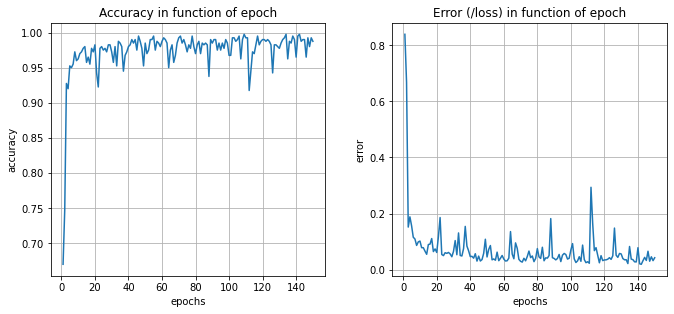

Accuracy on Test set : 0.956140350877193


In [6]:
AN = MLP()
AN.add_layer(nb_nodes=100, feat_size=nb_feat, activation = 'relu')
AN.BatchNormalization()
AN.add_layer(nb_nodes=100, activation = 'relu')
AN.BatchNormalization()
AN.add_layer(nb_nodes=100, activation = 'relu')
AN.BatchNormalization()
AN.add_layer(nb_nodes=100, activation = 'relu')
AN.BatchNormalization()
AN.add_layer(nb_nodes=100, activation = 'relu')
AN.BatchNormalization()
AN.add_layer(nb_nodes=50, activation = 'relu')
AN.BatchNormalization()
AN.add_layer(nb_nodes=2, activation = 'softmax')

AN.fit(X_train, Y_train)
AN.gradient_descent(gamma = 1e-2, epochs = 150, loss = "cross_entropy")
AN.training_curve()

y_pred = AN.predict(X_test)
print("Accuracy on Test set :", accuracy(y_pred, Y_test))

# K-fold cross validation

In [7]:
def K_fold_cross_validation(X, y, K=5):
    nb_samp = y.size
    test_size = nb_samp//K
    Test_sets = []
    Test_y = []
    Train_sets = []
    Train_y = []
    for i in range(K):
        Test_sets.append(X[i*test_size:(i+1)*test_size, :])
        Test_y.append(y[i*test_size:(i+1)*test_size])
        if i==0:
            Train_sets.append(X[(i+1)*test_size:,:])
            Train_y.append(y[(i+1)*test_size:])
        elif i==(K-1):
            Train_sets.append(X[:(i)*test_size,:])
            Train_y.append(y[:(i)*test_size])
        else :
            X_train = np.vstack((X[:i*test_size,:], X[(i+1)*test_size:,:]))
            if len(y.shape)<2:
                Y_train = np.hstack((y[:(i)*test_size], y[(i+1)*test_size:]))
            else:
                Y_train = np.vstack((y[:(i)*test_size], y[(i+1)*test_size:]))
            Train_sets.append(X_train)
            Train_y.append(Y_train)
    return Train_sets, Train_y, Test_sets, Test_y

In [8]:
Kfold = 6
Train_sets, Train_y, Test_sets, Test_y = K_fold_cross_validation(data[:,:-1], data[:,-1], K=Kfold)
acc = []
for i in range(Kfold):
    AN.fit(Train_sets[i], Train_y[i])
    AN.gradient_descent(gamma = 1e-2, epochs = 100, loss = "cross_entropy")
    y_pred = AN.predict(Test_sets[i])
    acc.append(accuracy(y_pred, Test_y[i]))
    print("Accuracy on Test set {} = {}".format(i, acc[i]))

avg_acc = np.mean(acc)
print("Average accuracy by X-validation = ", avg_acc)

batch size =  100
loss function :  cross_entropy
Epoch : 1,  Batch accuracy : 0.475 - Batch error = 1.1652557105152286
Epoch : 10,  Batch accuracy : 0.945 - Batch error = 0.1312867459246282
Epoch : 20,  Batch accuracy : 0.975 - Batch error = 0.07911543921754545
Epoch : 30,  Batch accuracy : 0.9825 - Batch error = 0.07174661897824225
Epoch : 40,  Batch accuracy : 0.9749999999999999 - Batch error = 0.06856468451477708
Epoch : 50,  Batch accuracy : 0.9825 - Batch error = 0.047863492602555804
Epoch : 60,  Batch accuracy : 0.9774999999999999 - Batch error = 0.06238185438961953
Epoch : 70,  Batch accuracy : 0.99 - Batch error = 0.03414303377408284
Epoch : 80,  Batch accuracy : 0.9874999999999999 - Batch error = 0.04010803479973001
Epoch : 90,  Batch accuracy : 0.935 - Batch error = 0.1766823345277338
Epoch : 100,  Batch accuracy : 0.99 - Batch error = 0.040705642962588474
Epoch : 100,  Batch accuracy : 0.99 - Batch error = 0.040705642962588474
Accuracy on Test set 0 = 0.9787234042553191
batc

In [9]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [114, 94]